NYC Taxi data for predicting the trip duration

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
DATA_PATH = "../data/nyc-taxi-trip-duration"
TRAIN_FILE_PATH = os.path.join(DATA_PATH, "train.csv")
TEST_FILE_PATH = os.path.join(DATA_PATH, "test.csv")
SAMPLE_SUB_FILE_PATH = os.path.join(DATA_PATH, "sample_submission.csv")
SUB_FILE_PATH = os.path.join(DATA_PATH, "submission.csv")

In [51]:
train = pd.read_csv(TRAIN_FILE_PATH, index_col="id", parse_dates=["pickup_datetime", "dropoff_datetime"])

In [52]:
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 122.4+ MB


In [54]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


#### Creation of train and validation set

In [55]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)
print(len(train_set), len(val_set))
train = train_set

1166915 291729


#### Boxplots

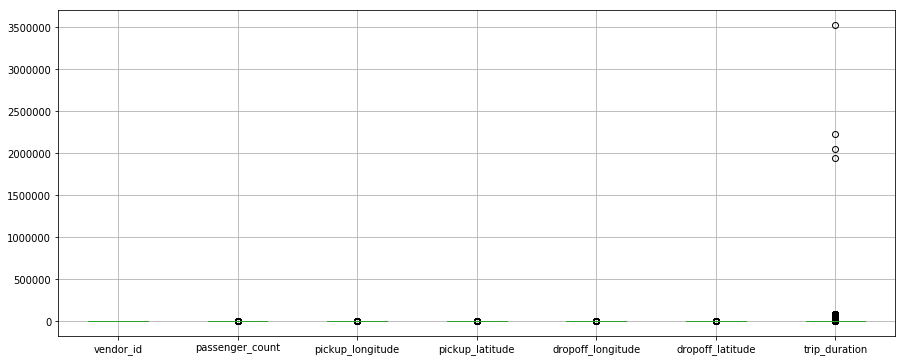

In [56]:
plt.subplots(figsize=(15, 6))
train.boxplot()

Boxplots reveals the trip_duration is has some extreme outliers.
Lets build a Transformer to clip these outliers

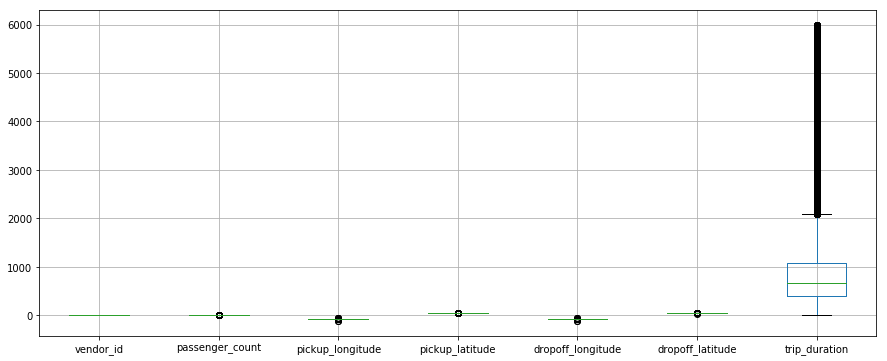

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class ClipOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name, lower_limit=None, upper_limit=None):
        self.attribute_name = attribute_name
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        if self.attribute_name not in df.columns:
            return df
        elif self.lower_limit != None:
            return df[df[self.attribute_name] > self.lower_limit]
        elif self.upper_limit != None:
            return df[df[self.attribute_name] < self.upper_limit]
        else:
            return df
        
clip_outliers_in_trip_duration = ClipOutliers("trip_duration", lower_limit=None, upper_limit=6000)
train_trip_duration_clipped = clip_outliers_in_trip_duration.fit_transform(train)
clip_outliers_in_passenger_count = ClipOutliers("passenger_count", lower_limit=0, upper_limit=None)
train_clipped = clip_outliers_in_trip_duration.fit_transform(train_trip_duration_clipped)
plt.subplots(figsize=(15, 6))
train_clipped.boxplot()

#### Get a feel of the data with Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000026534588>,
      dtype=object)

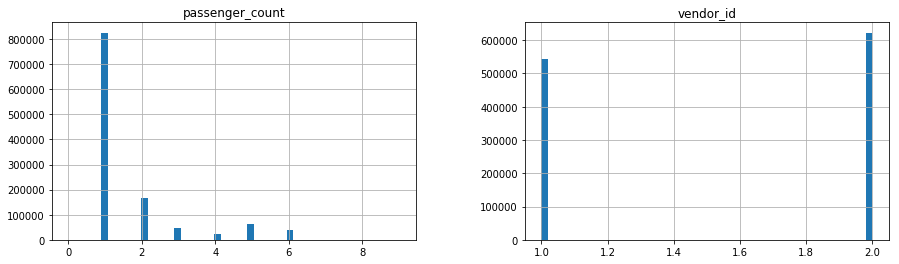

In [58]:
train_clipped[["passenger_count", "vendor_id"]].hist(bins=50, figsize=(15, 4))

### Discover and visualize data

In [59]:
taxi = train

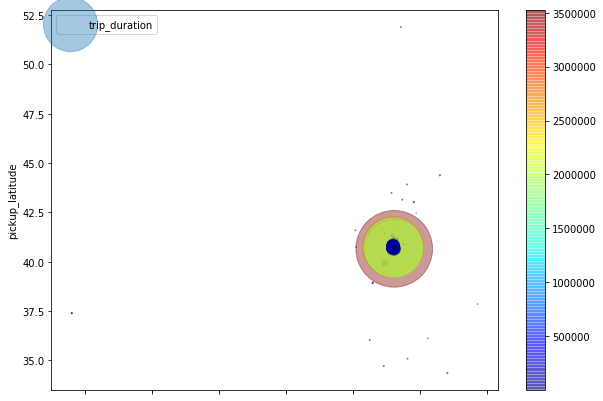

In [60]:
taxi.plot(kind='scatter', x="pickup_longitude", y="pickup_latitude", alpha=0.4,
            s=taxi["trip_duration"]/600, label="trip_duration", figsize=(10,7),
            c=taxi["trip_duration"], cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

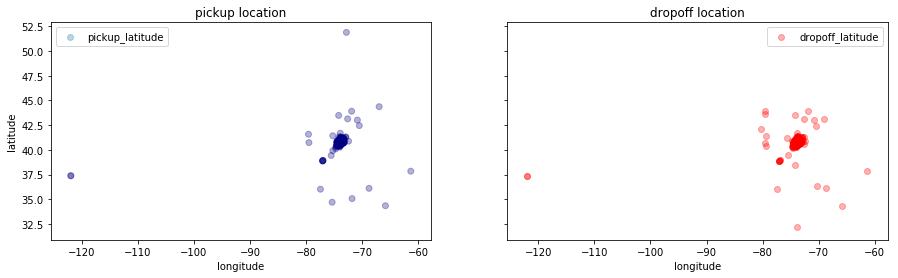

In [61]:
# Visualizing the pickup and dropoff locations
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,4))

axes[0].scatter(x=taxi["pickup_longitude"], y=taxi["pickup_latitude"], alpha=0.3,c=taxi["trip_duration"],
                cmap=plt.get_cmap("jet"),)
axes[0].legend()
axes[1].scatter(x=taxi["dropoff_longitude"], y=taxi["dropoff_latitude"], alpha=0.3,color="red")
axes[0].set_title("pickup location")
axes[0].set_xlabel("longitude")
axes[0].set_ylabel("latitude")
axes[1].set_xlabel("longitude")
axes[1].set_title("dropoff location")
plt.legend()
plt.show()

From the above plots, we could see that the pickup and dropoff locations are kind of clustered around.
So one good feature could be utilizing this information (could be a distance measure from mean latitude and longitude). 
Also we see an increase in trip_time when the pickup location is farther from these darker center cluster

In [62]:
pickup_mean_latitude = taxi[(taxi["pickup_latitude"] > 40.0) & (taxi["pickup_latitude"] < 42.0)]["pickup_latitude"].mean()
pickup_mean_longitude = taxi[(taxi["pickup_longitude"] > -74.2) & (taxi["pickup_longitude"] < -73.5)]["pickup_longitude"].mean()
print("pickup_mean_latitude = {}".format(pickup_mean_latitude))
print("pickup_mean_longitude = {}".format(pickup_mean_longitude))

dropoff_mean_latitude = taxi[(taxi["dropoff_latitude"] > 40.0) & (taxi["dropoff_latitude"] < 42.0)]["pickup_latitude"].mean()
dropoff_mean_longitude = taxi[(taxi["dropoff_longitude"] > -74.2) & (taxi["dropoff_longitude"] < -73.5)]["pickup_longitude"].mean()
print("dropoff_mean_latitude = {}".format(dropoff_mean_latitude))
print("dropoff_mean_longitude = {}".format(dropoff_mean_longitude))



pickup_mean_latitude = 40.75092996784608
pickup_mean_longitude = -73.97344649695415
dropoff_mean_latitude = 40.75093323520318
dropoff_mean_longitude = -73.97345960164967


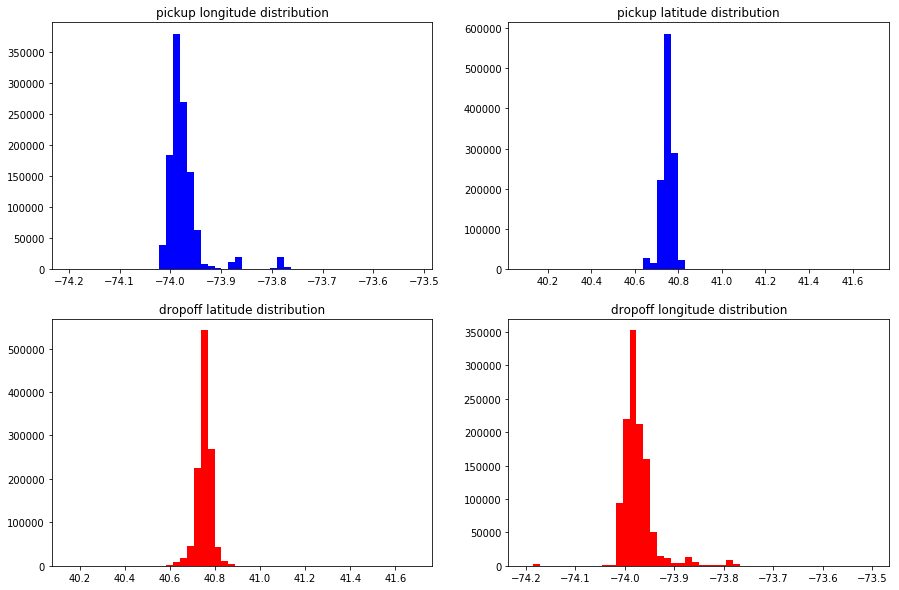

In [63]:
# Histogram of pickup and dropoff locations (latitudes and longitudes)
fig, axes = plt.subplots(2,2, sharex=False, sharey=False, figsize=(15,10))
pickup_longitude_spread = taxi[(taxi["pickup_longitude"] > -74.2) & (taxi["pickup_longitude"] < -73.5)]["pickup_longitude"]
axes[0,0].hist(pickup_longitude_spread, bins=50, color="blue")
axes[0,0].set_title("pickup longitude distribution")

pickup_latitude_spread = (taxi[(taxi["pickup_latitude"] > 40.0) & (taxi["pickup_latitude"] < 42.0)]["pickup_latitude"])
axes[0,1].hist(pickup_latitude_spread, bins=50, color="blue")
axes[0,1].set_title("pickup latitude distribution")

dropoff_latitude_spread = (taxi[(taxi["dropoff_latitude"] > 40.0) & (taxi["dropoff_latitude"] < 42.0)]["dropoff_latitude"])
axes[1,0].hist(dropoff_latitude_spread, bins=50, color="red")
axes[1,0].set_title("dropoff latitude distribution")

dropoff_longitude_spread = taxi[(taxi["dropoff_longitude"] > -74.2) & (taxi["dropoff_longitude"] < -73.5)]["dropoff_longitude"]
axes[1,1].hist(dropoff_longitude_spread, bins=50, color="red")
axes[1,1].set_title("dropoff longitude distribution")
plt.show()

In [64]:
# Building correlation matrix
def get_corr_info(df, feature="trip_duration"):
    corr_matrix = df.corr()
    return corr_matrix["trip_duration"].sort_values(ascending=False)

We don't find much correlation on the existing features with respect to trip_time

### Preparing the data

#### Creating DateAttribsAdder transformer

In [65]:
import datetime as dt

class DateAttribsAdder(BaseEstimator, TransformerMixin):
    def __init__(self, date_field):
        self.date_field = date_field
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["month"] = X.loc[:,self.date_field].dt.month
        X["week"] = X.loc[:,self.date_field].dt.week
        X["weekday"] = X.loc[:,self.date_field].dt.weekday
        X["day"] = X.loc[:,self.date_field].dt.day
        X["hour"] = X.loc[:,self.date_field].dt.hour
        X["minute"] = X.loc[:,self.date_field].dt.minute
        X["minute_of_the_day"] = X["hour"] * 60 + X.loc[:,self.date_field].dt.minute 
        return X.drop([self.date_field, "dropoff_datetime", "minute"], axis=1, errors="ignore")

date_attribs_adder = DateAttribsAdder("pickup_datetime")
date_attribs_added = date_attribs_adder.transform(taxi)
print(date_attribs_added.head())


           vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
id                                                                         
id0458976          2                1        -73.862762        40.768822   
id0434613          2                1        -73.958038        40.783237   
id3809234          2                1        -73.969460        40.785519   
id1203705          1                1        -73.981743        40.736549   
id1896645          2                1        -73.977913        40.752609   

           dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
id                                                                  
id0458976         -73.891701         40.746689                  N   
id0434613         -73.975510         40.760853                  N   
id3809234         -73.989243         40.771748                  N   
id1203705         -73.998352         40.726440                  N   
id1896645         -73.975647         40.733139       

In [66]:
cat_attribs = ["vendor_id", "store_and_fwd_flag"]
taxi_cat = taxi[cat_attribs]

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
taxi_1hot = cat_encoder.fit_transform(taxi_cat)
print(taxi_1hot.toarray())

[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 ...
 [0. 1. 1. 0.]
 [1. 0. 1. 0.]
 [0. 1. 1. 0.]]


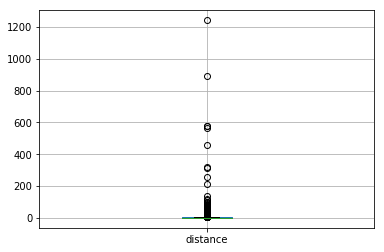

           vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
id                                                                              
id0458976          2 2016-06-29 18:21:02 2016-06-29 18:39:55                1   
id0434613          2 2016-04-25 13:03:26 2016-04-25 13:18:13                1   
id3809234          2 2016-05-07 12:36:09 2016-05-07 12:47:35                1   
id1203705          1 2016-05-14 18:44:17 2016-05-14 18:57:55                1   
id1896645          2 2016-04-10 22:51:25 2016-04-10 23:07:16                1   

           pickup_longitude  pickup_latitude  dropoff_longitude  \
id                                                                
id0458976        -73.862762        40.768822         -73.891701   
id0434613        -73.958038        40.783237         -73.975510   
id3809234        -73.969460        40.785519         -73.989243   
id1203705        -73.981743        40.736549         -73.998352   
id1896645        -73.977913   

In [67]:
%%time
from math import sin, cos, sqrt, atan2, radians

class DistanceAttribsAdder(BaseEstimator, TransformerMixin):
    def __init__(self, attrib_name = "distance"):
        self.attrib_name = attrib_name
        
    def fit(self, df):
        return self
    
    def transform(self, df, y=None):
        R=6373.0 # approximate radius of earth in km
        pickup_lat=np.radians(df['pickup_latitude'].values)
        pickup_lon=np.radians(df['pickup_longitude'].values)
        dropoff_lat=np.radians(df['dropoff_latitude'].values)
        dropoff_lon=np.radians(df['dropoff_longitude'].values)
        dlon = dropoff_lon - pickup_lon
        dlat = dropoff_lat - pickup_lat
        a = np.sin(dlat / 2)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        df["distance"] = R * c
        df.boxplot(column="distance", return_type="axes");
        plt.show()
        return df
        
distance_attribs_adder = DistanceAttribsAdder()
taxi_distance = distance_attribs_adder.transform(taxi)
print(taxi_distance.head())

# As we see outliers in the distance attribute, let's clip that out
clip_outliers_in_distance = ClipOutliers("distance", lower_limit=None, upper_limit=400)
taxi = clip_outliers_in_distance.fit_transform(taxi_distance)

In [68]:
## Creating a Pandas DropFeature transformer which drops the attributes from DataFrame and converts to numpy array
class DropFeature(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop([self.attribute_names],axis=1,errors="ignore").values

In [69]:
## Creating a Pandas FeatureSelector transformer which selects the attributes from DataFrame and converts to numpy array

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [70]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns = X.columns
        selected_features = [feature for feature in self.attribute_names if feature in columns ]
        return X[selected_features]

In [71]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.attribute_name] = np.log(X[self.attribute_name].values)
        return X

In [72]:
# categorical pipeline
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ('selector_cat', FeatureSelector(cat_attribs)),
    ("cat_trans", OneHotEncoder()),
])


In [73]:
num_attribs = ['pickup_datetime','passenger_count',
 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
 'trip_duration']

# Outlier rows removal piepline
outlier_pipeline = Pipeline([    
    ("clip_trip_duration", ClipOutliers("trip_duration", lower_limit=None, upper_limit=6000)),
    ("clip_passenger_count", ClipOutliers("passenger_count", lower_limit=0, upper_limit=None)),
    ("clip_pickup_longitude", ClipOutliers("pickup_longitude", lower_limit=-90, upper_limit=None)),
    ("clip_pickup_latitude", ClipOutliers("pickup_latitude", lower_limit=None, upper_limit=50)),
    ("dist_trans", DistanceAttribsAdder()),
    ("clip_distance", ClipOutliers("distance", lower_limit=None, upper_limit=400)),
])

# numerical attributes pipeline
num_pipeline = Pipeline([
    ('selector_num', DataFrameSelector(num_attribs)),
    ("date_tranform", DateAttribsAdder("pickup_datetime")),
    ("feature_dropper", DropFeature("trip_duration"))
])

In [74]:
# label creation pipeline
label_pipeline = Pipeline([
    ("clip_trip_duration", ClipOutliers("trip_duration", lower_limit=None, upper_limit=6000)),
    ('trip_log_transformer', LogTransformer("trip_duration")),
    ("feature_selector", FeatureSelector("trip_duration"))
])

In [75]:
# Create a Featureunion to join the two pipelines (numerical and categorical pipelines)

from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

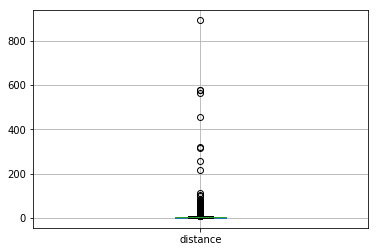

D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

(1164840, 15)


<1164840x15 sparse matrix of type '<class 'numpy.float64'>'
	with 14949440 stored elements in Compressed Sparse Row format>

In [76]:
# Feeding the outlier clipped transformed data into full_pipeline
outliers_clipped = outlier_pipeline.fit_transform(train)
taxi_prepared = full_pipeline.fit_transform(outliers_clipped)

# Running the label_pipeline
taxi_labels = label_pipeline.fit_transform(outliers_clipped)

print(taxi_prepared.shape)
taxi_prepared

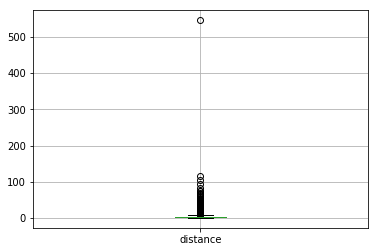

D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [77]:
# Validation data transformation
# Feeding the outlier clipped transformed data into full_pipeline
outliers_clipped_val = outlier_pipeline.fit_transform(val_set)
taxi_prepared_val = full_pipeline.fit_transform(outliers_clipped_val)

# Running the label_pipeline
taxi_labels_val = label_pipeline.fit_transform(outliers_clipped_val)

### Training and Model evaluation

In [78]:
# Trying RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor(n_estimators=100,min_samples_leaf=10, min_samples_split=15, max_features='auto', max_depth=90, bootstrap=True, n_jobs=-1)
forest_reg.fit(taxi_prepared, taxi_labels)

predictions = forest_reg.predict(taxi_prepared_val)

print(predictions[:5])
print(taxi_labels_val[:5])

score = np.sqrt(mean_squared_error(taxi_labels_val, predictions))
print("validation RMSE: {}".format(score))
print(forest_reg.feature_importances_)

# scores = cross_val_score(forest_reg, taxi_prepared, taxi_labels, scoring='neg_mean_squared_error', cv=5, test_split=0.2)
# forest_rmse_scores = np.sqrt(-scores)
# print("forest_rmse_scores: ", forest_rmse_scores)
# print("mean forest_rmse_scores: ", forest_rmse_scores.mean())
# print("std forest_rmse_scores: ", forest_rmse_scores.std())

[6.53695238 6.64231473 6.01300202 6.84897631 8.39426975]
[6.94697599 6.7178047  6.41999493 6.76503898 8.51057132]
validation RMSE: 0.3691870719585286
[1.45850416e-03 2.37428664e-01 2.57012046e-01 2.15968171e-01
 1.90212901e-01 3.34011626e-03 8.56485099e-03 1.87171838e-02
 8.13577894e-03 1.92433863e-03 5.44622101e-02 1.24730516e-03
 1.50643799e-03 1.41554267e-05 7.33559517e-06]


In [79]:
test = pd.read_csv(TEST_FILE_PATH, index_col="id", parse_dates=["pickup_datetime"])

In [80]:
test.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
id,,,,,,,,
id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


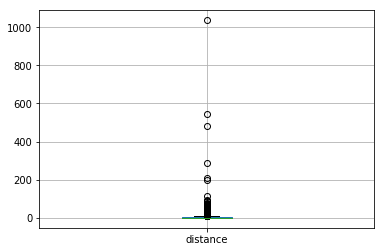

D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(625134, 15)


In [81]:
outliers_clipped_test = outlier_pipeline.fit_transform(test)
test_prepared = full_pipeline.fit_transform(test)
print(test_prepared.shape)

In [82]:
pred_test = np.exp(forest_reg.predict(test_prepared))

#### Submission

In [83]:
submit = pd.read_csv(SAMPLE_SUB_FILE_PATH)
submit.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [84]:
submit["trip_duration"] = pred_test
submit.head()

,id,trip_duration
0,id3004672,737.442896
1,id3505355,621.981868
2,id1217141,514.440735
3,id2150126,1029.827885
4,id1598245,331.124786


In [85]:
submit.to_csv("submission.csv", index=False)